<AxesSubplot:ylabel='Count'>

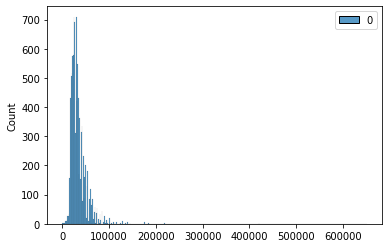

In [1]:
%matplotlib inline
import os
import pandas as pd
import seaborn as sns

data = pd.read_csv(os.getcwd() + "/salary.csv", header=None)
sns.histplot(data)


It would be good if seaborn returned the bins and the counts! According to the docs it just uses numpy anyway...

<BarContainer object of 425 artists>

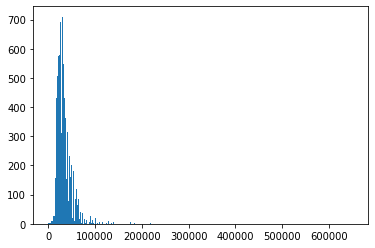

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x = data[0].values
counts, bin_edges = np.histogram(x, bins='auto')
plt.bar( bin_edges[:-1], counts, width=np.diff(bin_edges),  align='edge' )

The 'auto' parameter uses some fancy estimator of the optimal number of bins. Let's see how this works...

#### Basic Variables
Assume the x values are in $[0,1]$ (if not scale them).<br> 
Let the count in a bin be $\nu_i$.<br>
The total number of observations is $n = \sum_i \nu_i$. This is fixed.<br>
The number of bins is $m$ and therefore the bin width is $a = 1/m$. This is what we want to tune.<br>

#### Relating probabilities and fucntions
We assume there is some smooth function $f(x)$, which we are approximating with the histogram. If $x$ is in the bin $B$ then 
$$\hat{p}_n(B) = \frac{\nu_i }{ n }$$ 
is our estimate of the probability of an observation falling in the bin. We use $n$ observations to construct this probability, hence the subscript. When we take expectations in a minute, we are taking expectations over many different samples of size $n$. 

An estimate of the function $f$ is 
$$
\hat{f}_n(x) = \frac{\hat{p}_n(B)}{a}
$$
Because
$$
E[ \hat{f}_n(x) ] = \frac{ E[ \hat{p}_n(B) ]}{a} = \frac{p(B)}{a} = \frac{1}{a} \int_B f(u)du \simeq \langle f \rangle_B
$$
We used that the expected number of hits in $B$ is given by the proportion of the area under the function covered by $B$, that is $\frac{\int_B f}{\int f} = \int_B f$, where we assume the total area is 1. Then the value of an integral is the average value of a function in a region, $\langle f \rangle_B$ times the width of the region, $|B| = a$. Basically $p$ and $f$ are the same thing, just with factors of $a$ which I will put back at the end.

#### Estimating the error we make
An estimate of the error we make approximating the function $f$ is
$$
\int (\hat{f}_n - f)^2 = \int \hat{f}_n^2 - 2 \int \hat{f}_n f + \int f^2
$$
The last part is fixed by whatever the function $f$, is so a good estimator will minimise the rest
$$
L =  \int \hat{f}_n^2 - 2 \int f \hat{f}_n
$$
We want the average over all possible $n$-tuples of data to be small so really we minimise
$$
J = E[L]
$$

#### Deriving the magic formula
One way to do this (from [this](https://egrcc.github.io/docs/math/all-of-statistics.pdf) via [this](https://digitalassets.lib.berkeley.edu/sdtr/ucb/text/34.pdf)) relies on a mysterious identity. To understand it, fix a bin $B$. The chance of a value falling in this bin is $p(B)$ and the chance of it falling elsewhere is $1 - p(B)$. This is just a Bernoulli process so we can say that with $n$ observations we expect
$$
E[\hat{p}_n] = p
$$
and
$$
Var[\hat{p}_n] = \frac{p(1-p)}{n}
$$
I've put the factors of $a$ back in, and note there's only 1 factor of $n$ in the variance. 

The last equation can be rewritten in a weird way
$$
Var[\hat{p}_n] = E[\hat{p}_n^2] - E[\hat{p}_n]^2 = E[\hat{p}_n^2] - p^2 = \frac{1}{n}(p - p^2)
$$
Rearranging
$$
\frac{1}{n-1}\left( n E[\hat{p}_n^2] - p \right) = p^2
$$
This is kind of like Bessel's correction for standard deviation, we remove the bias for an estimate of $p^2$.

#### Putting it together
Push the expectations (over many size $n$ samples) through the integrals (over the range of the function) to get
$$
J = \int E[\hat{f}_n^2] - 2 \int E[ f \hat{f}_n ] = \int E[\hat{f}_n^2] - 2 \int f^2
$$
Using the magic formula and taking out the factors of $a$ gives
$$
J = \frac{1}{a} \int E[\hat{p}_n^2] -  \frac{2}{n-1}\left( n E[\hat{p}_n^2] - p \right)
$$
Which simplifies to
$$
J = \frac{1}{a} \left( \int E[\hat{p}_n^2](1 -  \frac{2n}{n-1}) + \int \frac{2p}{n-1} \right)\\
= \frac{1}{a} \left(  \frac{2}{n-1} - \frac{n+1}{n-1}\int E[\hat{p}_n^2] \right)
$$
The integral of the histogram is just a sum of rectangles, so it just turns into a sum over bins
$$
J = \frac{2}{a(n-1)} - \frac{n+1}{a(n-1)}\sum_B \hat{p}_n^2
$$
Note only the first term has an explicit factor of bin width.

##### The code below is (basically) what is called the "Stone" method in numpy

35
33


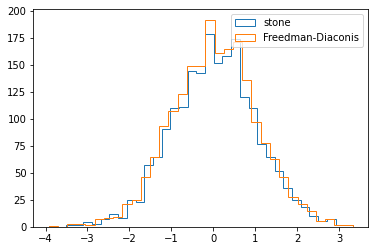

In [3]:
def simple_hist(x, n):
    bin_edges = np.linspace(x.min(), x.max(), n+1)
    sx = np.sort(x)
    ##any sane programmer would write a simple for loop here, something like
    #counts = np.zeros(n)
    #bin_id = 0
    #for val in sx:
    #    while val > bin_edge[bin_id+1]: bin_id += 1
    #    counts[bin_id] += 1
    #...but we are in numpy land, so have to do some weird voodoo
    indices = np.searchsorted(sx, bin_edges[:-1], side='left')
    counts = np.append( np.diff(indices), len(x) - indices[-1] )   
    return bin_edges, counts

def J(data, nbins):
    width = (data.max() - data.min())
    n = len(data)
    bin_edges, counts = simple_hist(data,nbins)
    a = width/nbins;
    return ( 2./n - counts.dot(counts)/(n*n) )/a 

tx = np.random.normal(0,1,2000) 

stone_bins = np.argmin( np.array([ J(tx, i) for i in range(2,40) ]) ) + 2
print(stone_bins)

iqr = np.subtract(*np.percentile(tx, [75, 25]))
fd_w = 2.0 * iqr * tx.size ** (-1.0 / 3.0)
fd_bins = int((tx.max() - tx.min())/fd_w)
print(fd_bins)

counts, bins, artists = plt.hist(tx, bins=stone_bins, label="stone", histtype='step')
counts, bins, artists = plt.hist(tx, bins=fd_bins, label="Freedman-Diaconis",  histtype='step')
plt.legend()

Comparing the stone estimate above to the Freedman Diaconis estimate (a different, easier to compute one!) Works fine for Normal data. For data with "fine details" like below, it works way better than the FD estimate.

119
19


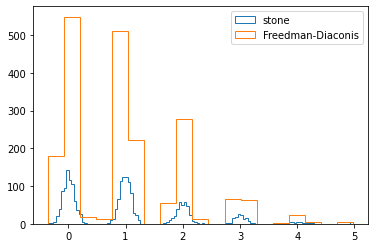

In [4]:
tx = np.random.poisson(1,2000) + np.random.normal(0,0.1,2000)

stone_bins = np.argmin( np.array([ J(tx, i) for i in range(2,200) ]) ) + 2
print(stone_bins)

iqr = np.subtract(*np.percentile(tx, [75, 25]))
fd_w = 2.0 * iqr * tx.size ** (-1.0 / 3.0)
fd_bins = int((tx.max() - tx.min())/fd_w)
print(fd_bins)

counts, bins, artists = plt.hist(tx, bins=stone_bins, label="stone", histtype='step')
counts, bins, artists = plt.hist(tx, bins=fd_bins, label="Freedman-Diaconis", histtype='step')
plt.legend()

6 10
11


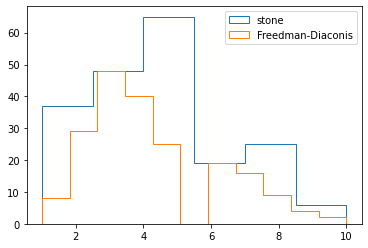

In [5]:
tx = np.random.poisson(4,200) 
stone_bins = np.argmin( np.array([ J(tx, i) for i in range(1, len(set(tx))) ]) ) + 2
print(stone_bins, len(set(tx)))

iqr = np.subtract(*np.percentile(tx, [75, 25]))
fd_w = 2.0 * iqr * tx.size ** (-1.0 / 3.0)
fd_bins = int((tx.max() - tx.min())/fd_w)
print(fd_bins)

counts, bins, artists = plt.hist(tx, bins=stone_bins, label="stone", histtype='step')
counts, bins, artists = plt.hist(tx, bins=fd_bins, label="Freedman-Diaconis", histtype='step')
plt.legend()

Say we have $K$ observations of the same integer then there will always be a bin $B$, with at least $K$ counts in it, contributing $K^2$ to the sum so
$$
-p_n(B)/a = -K^2/a
$$
can get arbitrarily small by just making $a$ as small as possible. Can get it to work if you restrict to have no more than 1 bin per count.

### Cross Validation

Again, the Risk is
$$
J = \int \hat{f_n}^2 - 2 \int \hat{f_n} f
$$
The first term is the sum of squares of the histogram heights, easy enough to compute. The second term is (-2 times) the average height of the histogram (treating $f$ like a probability density). A (very expensive) estimate of the second term is 
1. Compute $f_{n, -i}$ the histogram without the data point $X_i$. 
2. Use that histogram to estimate $f$ at $X_i$.
3. Do this for all data points and average.

13
7
14


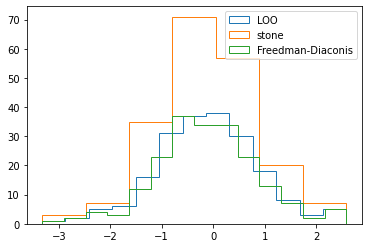

In [6]:
def simple_hist_range(x, n, xmin, xmax):
    bin_edges = np.linspace(xmin, xmax, n+1)
    sx = np.sort(x)
    ##any sane programmer would write a simple for loop here, something like
    #counts = np.zeros(n)
    #bin_id = 0
    #for val in sx:
    #    while val > bin_edge[bin_id+1]: bin_id += 1
    #    counts[bin_id] += 1
    #...but we are in numpy land, so have to do some weird voodoo
    indices = np.searchsorted(sx, bin_edges[:-1], side='left')
    counts = np.append( np.diff(indices), len(x) - indices[-1] )   
    return bin_edges, counts


def Jloo(data, nbins):
    width = (data.max() - data.min())
    n = len(data)
    bin_edges, counts = simple_hist(data,nbins)
    a = width/nbins;
    
    J1 = counts.dot(counts)/(n*n)
    
    av_hist = 0
    for b in range(n):
        _data = np.concatenate( (data[:b] , data[b+1:]) )
        bin_edges, _counts = simple_hist_range(_data, nbins, data.min(), data.max())
        idx = min(np.argmin( np.abs(data[b] - bin_edges)), nbins-1 )        
        av_hist += _counts[idx]/n
    av_hist /= n;
    #print(J1, av_hist)
    return (J1 - 2*av_hist)/a


tx = np.random.normal(0,1,200) 
#vals = np.array([ Jloo(tx, i) for i in range(2,200) ]) 
#plt.scatter(range(2,200), vals)

loo_bins = np.argmin( np.array([ Jloo(tx, i) for i in range(2,40) ]) ) + 2
print(loo_bins)

stone_bins = np.argmin( np.array([ J(tx, i) for i in range(2,40) ]) ) + 2
print(stone_bins)

iqr = np.subtract(*np.percentile(tx, [75, 25]))
fd_w = 2.0 * iqr * tx.size ** (-1.0 / 3.0)
fd_bins = int((tx.max() - tx.min())/fd_w)
print(fd_bins)

counts, bins, artists = plt.hist(tx, bins=loo_bins, label="LOO",  histtype='step')
counts, bins, artists = plt.hist(tx, bins=stone_bins, label="stone", histtype='step')
counts, bins, artists = plt.hist(tx, bins=fd_bins, label="Freedman-Diaconis",  histtype='step')

plt.legend()


For many data points this is expensive. It also doesn't seem particularly good.

#### Bands

Histograms like everything else, should have error bars. There is an error estimate (see [here](https://egrcc.github.io/docs/math/all-of-statistics.pdf) Theorem 20.10) but we can try bootstrap instead.

<BarContainer object of 19 artists>

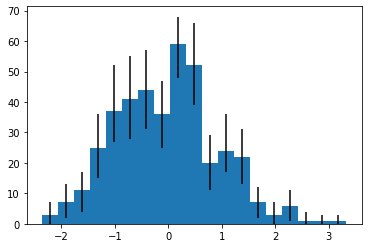

In [11]:
np.random.seed(1243455361)
tx = np.random.normal(0,1,400) 

stone_bins = np.argmin( np.array([ J(tx, i) for i in range(2,40) ]) ) + 2

bin_edges, counts = simple_hist(tx, stone_bins)

def boots(data, nbins, Nboots=100, conf=0.95):
    
    samples = np.empty( (Nboots,nbins) )
    edge_pc = (1-conf)/2
    for b in range(Nboots):
        _data = np.random.choice(data, len(data), replace=True)
        bin_edges, counts = simple_hist_range(_data, nbins, data.min(), data.max())
        samples[b] = counts
    sd = np.sort(samples, axis=0)
    lower = sd[ int( edge_pc*Nboots )  ]
    upper = sd[ int( (1-edge_pc)*Nboots )  ]

    return lower, upper
lower, upper = boots(tx, stone_bins)

plt.bar( bin_edges[:-1], counts, width=np.diff(bin_edges),  align='edge', yerr=np.array( [counts-lower, upper-counts] ) )




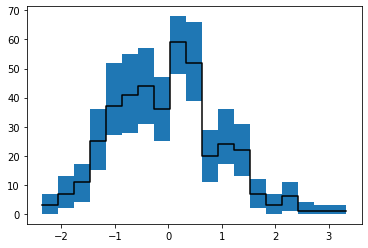

In [19]:
##make bands, have to mess around with the data a bit
lb = [lower[0], lower[0]]
ub = [upper[0], upper[0]]
xv = [bin_edges[0], bin_edges[1]]
center = [counts[0], counts[0]]
for i in range(1,len(lower)):
    xv.extend( [bin_edges[i], bin_edges[i+1]] )
    lb.extend( [lower[i], lower[i]] )
    ub.extend( [upper[i], upper[i]] )
    center.extend( [counts[i], counts[i]] )
plt.fill_between(xv, lb, ub)
plt.plot(xv, center, c='k')

Try it on the salary data

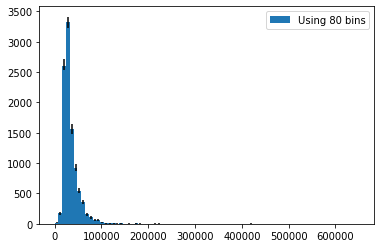

In [20]:
data = pd.read_csv(os.getcwd() + "/salary.csv", header=None)
x = data[0].values
stone_bins = np.argmin( np.array([ J(x, i) for i in range(2,100) ]) ) + 2

bin_edges, counts = simple_hist(x, stone_bins)
lower, upper = boots(x, stone_bins)

plt.bar( bin_edges[:-1], counts, width=np.diff(bin_edges),  align='edge', yerr=np.array( [counts-lower, upper-counts] ), label="Using {} bins".format(stone_bins) )
plt.legend();

#### Bias-variance trade-off
There is an interesting relationship that tells us how good a histogram can possibly be at representing the true distribution. Recall the integrated squared error is
$$
L = \int (f - \hat{f_n})^2
$$
and the risk is
$$
R = E[L]
$$
Define the bias (how close the expected estimate is to the true value)
$$
b = E[ \hat{f_n} ] - f
$$
and the variance (how noisy the estimates are)
$$
v = E[ (\hat{f_n} - E[ \hat{f_n} ])^2 ]
$$
Subbing in and doing many cancellations shows that
$$
R = \int b^2 + \int v
$$

#### Histograms and bias-variace

Using a histogram to estimate $f$ the bias is
$$
b(x) = E[ \hat{f_n}(x) ] - f(x) = \frac{p(B)}{h} - f(x)
$$
Where $x \in B$. Recall $p(B)$ is the average value of $f$ in $B$ so $p(B) = \int_B f(u) du$. Using a very ropey approximation,
$$
f(u) \simeq f(x) + f'(x) (u-x)
$$
Doing the integral, assuming we have a very small rectangle and that $B$ is the $j$th bin, 
$$
p(B) \simeq hf(x) + h f'(x) ( hj - x )
$$
Hence
$$
b(x) = f'(x) ( hj - x )
$$
If $f$ is constant in the bin then
$$
\int_B b^2 \simeq f'(x)^2 \int_B ( hj - x )^2 dx = c_1 f'(x)^2 h^3
$$
for some constant $c_1$. Summing up all the bins to get the total bias
$$
\int b^2 \simeq \sum^m c_1 f'(x)^2 h^3 = c_1 h^2 \sum^m h f'(x)^2 \simeq c_1 h^2 \int f'(x)^2
$$
The important thing is the factor of $h^2$ (also, assuming all the integrals exist).

Recall the variance
$$
v = \frac{p_j(1-p_j)}{nh^2}
$$
Using the same Taylor expansion and keeping only the lowest order terms (in $h$)
$$
v(x) \simeq \frac{f(x)}{nh}
$$
So
$$
\int v = \frac{1}{nh}
$$


The Risk is therefore
$$
R = c_2 h^2 + \frac{1}{nh}
$$
Minimising this implies
$$
\frac{dR}{dh} = 0 \implies h \sim \frac{1}{n^{1/3}} 
$$
So
$$
R \sim c_3 n^{-2/3} + c_4 \frac{1}{n (n^{-1/3}) } \\
R \sim n^{-2/3}
$$

So, if you pick a perfect bin width the error decreases like $n^{-2/3}$. The optimal value of $h$ given here requires knowing the function $f$ so we can't use it. This rate of decrease is not bad but not great either. Turns out an optimal KDE can go like $n^{-4/5}$, which is the best possible rate for a non-parametric estimator.